In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [20]:
df = pd.read_csv('./data/total_0509.csv')

In [21]:
cols = list(df.columns)
cols.remove('Date')

In [22]:
df.isnull().sum()

Unnamed: 0        0
Date              0
EURO_conf         0
CHINA_conf        0
ASIA_conf         0
N_AMERICA_conf    0
NZ_conf           0
EURO_roam         0
CHINA_roam        0
ASIA_roam         0
N_AMERICA_roam    0
NZ_roam           0
TARGET            0
NEWS              0
covid_tr          0
coro_tr           0
dtype: int64

In [23]:
df[cols] = df[cols].astype(int)

In [24]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [25]:
tmp_cols = ['EURO_conf','CHINA_conf','ASIA_conf','N_AMERICA_conf','NZ_conf','TARGET']

In [26]:
for i in tmp_cols:
    df['{}'.format(i)] = df['{}'.format(i)].diff()

In [27]:
df.fillna(0, inplace=True)

In [28]:
df.Date = pd.to_datetime(df.Date)
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [29]:
df.rename(columns={'TARGET':'target'},inplace=True)

In [30]:
plt.style.use('ggplot')

## lag 변수 생성

In [31]:
df.columns

Index(['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'N_AMERICA_conf', 'NZ_conf',
       'EURO_roam', 'CHINA_roam', 'ASIA_roam', 'N_AMERICA_roam', 'NZ_roam',
       'target', 'NEWS', 'covid_tr', 'coro_tr', 'dayofweek'],
      dtype='object')

In [32]:
lag_col = ['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'N_AMERICA_conf', 'NZ_conf',
       'EURO_roam', 'CHINA_roam', 'ASIA_roam', 'N_AMERICA_roam', 'NZ_roam',
       'target', 'NEWS', 'covid_tr', 'coro_tr']

In [33]:
lag_amount = 1

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [34]:
df.tail()

,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,NZ_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,NZ_roam,...,NZ_conf_lag1,EURO_roam_lag1,CHINA_roam_lag1,ASIA_roam_lag1,N_AMERICA_roam_lag1,NZ_roam_lag1,target_lag1,NEWS_lag1,covid_tr_lag1,coro_tr_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,9243.0,3.0,5645.0,35923.0,6.0,24,230,247,126,0,...,3.0,62.0,152.0,221.0,124.0,0.0,4.0,1266.0,43.0,18.0
2020-05-02,11965.0,0.0,5006.0,30661.0,2.0,77,90,254,174,0,...,6.0,24.0,230.0,247.0,126.0,0.0,8.0,1104.0,48.0,18.0
2020-05-03,7719.0,5.0,5416.0,28079.0,0.0,48,130,248,104,0,...,2.0,77.0,90.0,254.0,174.0,0.0,8.0,732.0,43.0,18.0
2020-05-04,6902.0,2.0,6319.0,23788.0,-1.0,51,94,238,95,0,...,0.0,48.0,130.0,248.0,104.0,0.0,10.0,821.0,55.0,18.0
2020-05-05,8763.0,2.0,5515.0,25234.0,2.0,18,142,278,129,0,...,-1.0,51.0,94.0,238.0,95.0,0.0,8.0,1331.0,30.0,17.0


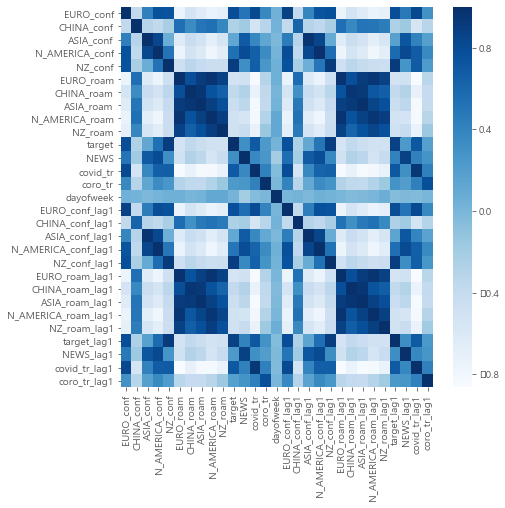

In [35]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap='Blues')

In [552]:
df['llag'] = df['lag1'] * df['lag-1']

In [553]:
df['Nlag'] = df['NZ_conf'] * df['lag-1']

In [15]:
df.__len__()

103

In [39]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove("target")
#new_x_cols = ['NZ_conf','covid_tr','EURO_conf', 'lag1']
# train / test split 범위 지정
test_data_size = 14

# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

# X 변수 Scale 적용
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [40]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

# 1. Random Forest

### 2-1. 모델생성

#### 2-1-1) 기본 옵션으로 모델 생성

In [42]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(rf_uncustomized.score(X_test,y_test)))

Score on training set : 0.973
Score on test set : -0.375


#### 2-1-2) 현재 생성된 트리 모델의 옵션 확인

In [43]:
rf_uncustomized

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### 2-2. 모델 Parameter 조정

#### 2-2-1) n_estimator : 트리 수 변경에 따른 모델 성능

In [44]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,40)]

for v_n_estimators in para_n_tree :
    rf = RandomForestRegressor(n_estimators= v_n_estimators)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))

# 결과 저장

df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score
df_score_n['Gap'] = df_score_n['TrainScore'] - df_score_n['TestScore']

In [45]:
# 모델 설명력 확인
df_score_n.round(3).sort_values(by='Gap').head()

,n_estimators,TrainScore,TestScore,Gap
3,40,0.971,-0.125,1.096
8,90,0.973,-0.203,1.175
9,100,0.970,-0.226,1.196
25,260,0.975,-0.272,1.248
5,60,0.974,-0.281,1.255


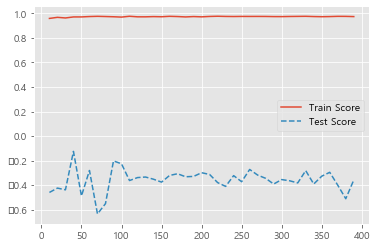

In [46]:
# 모델 설명력 그래프 확인

plt.plot(para_n_tree, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

#### 2-2-2) min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [47]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf :
    rf = RandomForestRegressor(n_estimators=40,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))
    
# 결과 저장

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
df_score_leaf['Gap'] = df_score_leaf['TrainScore'] - df_score_leaf['TestScore']

In [48]:
# 모델 설명력 확인
df_score_leaf.round(3).sort_values(by='Gap').head()

,MinSamplesLeaf,TrainScore,TestScore,Gap
4,5,0.930,-0.360,1.290
2,3,0.949,-0.365,1.315
5,6,0.906,-0.442,1.348
3,4,0.941,-0.453,1.394
13,14,0.825,-0.581,1.406


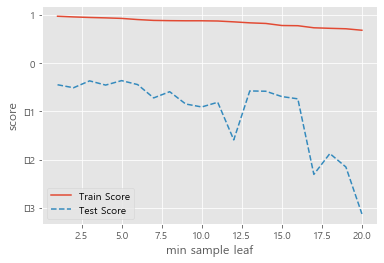

In [49]:
# 모델 설명력 그래프 확인

plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("min sample leaf")
plt.legend()

#### 2-2-3) min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [51]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2,41)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(n_estimators=40,
                                 min_samples_leaf = 5,
                                min_samples_split = v_min_samples_split)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test, y_test))
    
# 결과 저장

df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split['Gap'] = df_score_split['TrainScore'] - df_score_split['TestScore']

In [52]:
# 모델 설명력 확인
df_score_split.round(3).sort_values(by='Gap').head()

,MinSamplesSplit,TrainScore,TestScore,Gap
26,56,0.658,-0.058,0.716
27,58,0.569,-0.174,0.744
21,46,0.883,-0.273,1.156
0,4,0.921,-0.344,1.265
13,30,0.878,-0.401,1.280


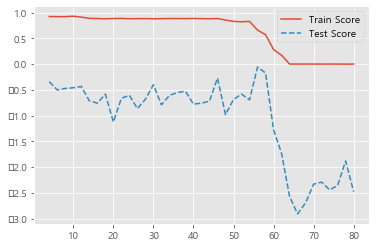

In [53]:
# 모델 설명력 그래프 확인

plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

40, 3 ,4

# 2. SVM Regressor

### 2-1. 모델생성

#### 2-1-1) 기본 옵션으로 모델 생성

In [70]:
svm_uncustomized = SVR()
svm_uncustomized.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(svm_uncustomized.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(svm_uncustomized.score(X_test,y_test)))

Score on training set : 0.420
Score on test set : -0.263


#### 2-1-2) 현재 생성된 트리 모델의 옵션 확인

In [71]:
svm_uncustomized

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### 2-2. 모델 Parameter 조정

#### 2-2-1) C 규제 변경

In [72]:
train_score = []; test_score = []

para_C = [10 ** c for c in range(-2,5)] # 참조 para_c : [0.01,0.1,1,10,100]

for v_C in para_C :
    svm = SVR(C = v_C)
    svm.fit(X_train, y_train)
    train_score.append(svm.score(X_train, y_train))
    test_score.append(svm.score(X_test, y_test))
    
# 모델 설명력 저장

df_score_C = pd.DataFrame()
df_score_C['C'] = para_C
df_score_C['TrainScore'] = train_score
df_score_C['TestScore'] = test_score
df_score_C['Gap'] = df_score_C['TrainScore'] - df_score_C['TestScore']

In [73]:
# 모델 설명력 확인
df_score_C.round(3).sort_values(by='Gap').head()

,C,TrainScore,TestScore,Gap
2,1.0,0.420,-0.263,0.684
3,10.0,0.906,0.027,0.879
1,0.1,-0.173,-1.234,1.061
5,1000.0,1.000,-0.898,1.898
6,10000.0,1.000,-0.923,1.923


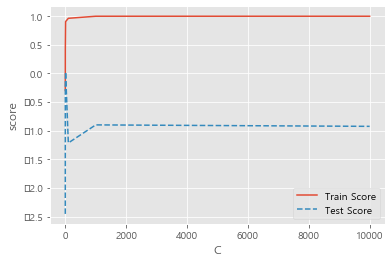

In [74]:
# 모델 설명력 그래프 확인

plt.plot(para_C, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_C, test_score, linestyle = '--', label = 'Test Score')

plt.ylabel("score"); plt.xlabel('C')
plt.legend()

In [76]:
train_score = []; test_score = []

para_gamma = [10 ** gamma for gamma in range(-2,3)]

for v_gamma in para_gamma :
    svm = SVR(gamma=v_gamma,
              C = 1.0)
    svm.fit(X_train, y_train)
    train_score.append(svm.score(X_train, y_train))
    test_score.append(svm.score(X_test,y_test))
    
# 결과 저장

df_score_gamma = pd.DataFrame()
df_score_gamma['gamma'] = para_gamma
df_score_gamma['TrainScore'] = train_score
df_score_gamma['TestScore'] = test_score
df_score_gamma['Gap'] = df_score_gamma['TrainScore'] - df_score_gamma['TestScore']

In [77]:
df_score_gamma.round(3).sort_values(by='Gap').head()

,gamma,TrainScore,TestScore,Gap
1,0.10,0.203,-0.070,0.272
0,0.01,0.349,-0.754,1.103
2,1.00,-0.231,-2.605,2.374
3,10.00,-0.243,-2.720,2.477
4,100.00,-0.243,-2.720,2.477


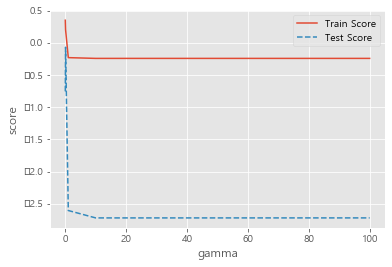

In [78]:
# 모델 설명력 그래프 확인

plt.plot(para_gamma, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_gamma, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("gamma")
plt.legend()

#### 2-2-2) epsilon 변경

In [79]:
train_score = []; test_score = []

para_epsilon = [eps/20 for eps in range(1,21)]

for v_epsilon in para_epsilon :
    svm = SVR(epsilon=v_epsilon,
              C = 1.0,
             gamma = 0.1)
    svm.fit(X_train, y_train)
    train_score.append(svm.score(X_train, y_train))
    test_score.append(svm.score(X_test,y_test))
    
# 결과 저장

df_score_epsilon = pd.DataFrame()
df_score_epsilon['epsilon'] = para_epsilon
df_score_epsilon['TrainScore'] = train_score
df_score_epsilon['TestScore'] = test_score
df_score_epsilon['Gap'] = df_score_epsilon['TrainScore'] - df_score_epsilon['TestScore']

In [80]:
# 모델 설명력 확인
df_score_epsilon.round(3).sort_values(by='Gap').head()

,epsilon,TrainScore,TestScore,Gap
17,0.90,0.225,-0.030,0.255
16,0.85,0.223,-0.032,0.255
15,0.80,0.221,-0.034,0.255
14,0.75,0.218,-0.037,0.255
18,0.95,0.227,-0.029,0.256


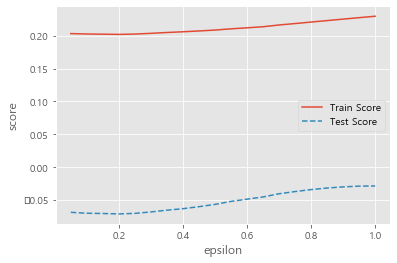

In [81]:
# 모델 설명력 그래프 확인

plt.plot(para_epsilon, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_epsilon, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("epsilon")
plt.legend()

## SVM model 생성

In [83]:
svr_final = SVR(C = 1.0,
               gamma = 0.1,
               epsilon = 0.9)
svr_final.fit(X_train, y_train)

print('Score on training set : {:.3f}'.format(svr_final.score(X_train, y_train)))
print("Score on test set : {:.3f}".format(svr_final.score(X_test, y_test)))

Score on training set : 0.225
Score on test set : -0.030


In [84]:
svr_final

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.9, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [85]:
estimators = [('rf', RandomForestRegressor(n_estimators=40,
                                           min_samples_split = 56)),
              ('svr', SVR(C = 1.0,
               gamma = 0.1,
               epsilon = 0.9))]

In [86]:
reg = StackingRegressor(estimators=estimators)

In [87]:
reg.fit(X_train, y_train).score(X_test, y_test)

-105.1156157777166

# Feature Selection 1

In [88]:
X_cols = list(df.columns)
X_cols.remove('target')

In [89]:
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

In [90]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [91]:
# parameter 설정
rf = RandomForestRegressor(n_estimators=90, min_samples_split=8, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [92]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(20)

,Feature,Importance
18,NZ_conf_lag1,0.427
4,NZ_conf,0.181
24,target_lag1,0.128
11,covid_tr,0.072
26,covid_tr_lag1,0.056
0,EURO_conf,0.036
14,EURO_conf_lag1,0.022
25,NEWS_lag1,0.020
1,CHINA_conf,0.012
7,ASIA_roam,0.006


In [93]:
new_importance = df_importance[df_importance['Importance'] > 0.01]

In [94]:
new_importance

,Feature,Importance
18,NZ_conf_lag1,0.426724
4,NZ_conf,0.180851
24,target_lag1,0.128182
11,covid_tr,0.071733
26,covid_tr_lag1,0.056313
0,EURO_conf,0.036333
14,EURO_conf_lag1,0.022297
25,NEWS_lag1,0.019879
1,CHINA_conf,0.012010


Text(0, 0.5, '변수')

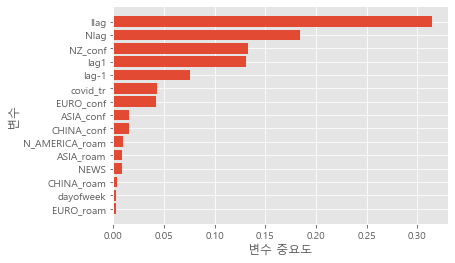

In [537]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(15)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# Stacking Model Prediction

In [95]:
# 변수명 지정
X_cols = list(new_importance.Feature)

# train / test split 범위 지정
test_data_size = 14

# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

# X 변수 Scale 적용
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [96]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [97]:
# build model
Stacking_Model = StackingRegressor(estimators=estimators)

labels = y_train
features = X_train

# Fit the RF model with features and labels.
st_reg=Stacking_Model.fit(features, labels)

In [98]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    st_reg.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    st_reg.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
SR_predict = X_train_predict.append(X_test_predict)

In [99]:
st_reg.predict(X_test)

array([29.43432893, 30.48592358, 28.71953962, 27.26175094, 27.15735104,
       27.84288857, 28.61703119, 29.00198937, 25.7586136 , 25.58833178,
       25.81642875, 24.88627266, 23.23354193, 22.6783895 ])

In [100]:
SR_predict.set_index(pd.to_datetime(df.index, format='%Y%m%d'), inplace=True)

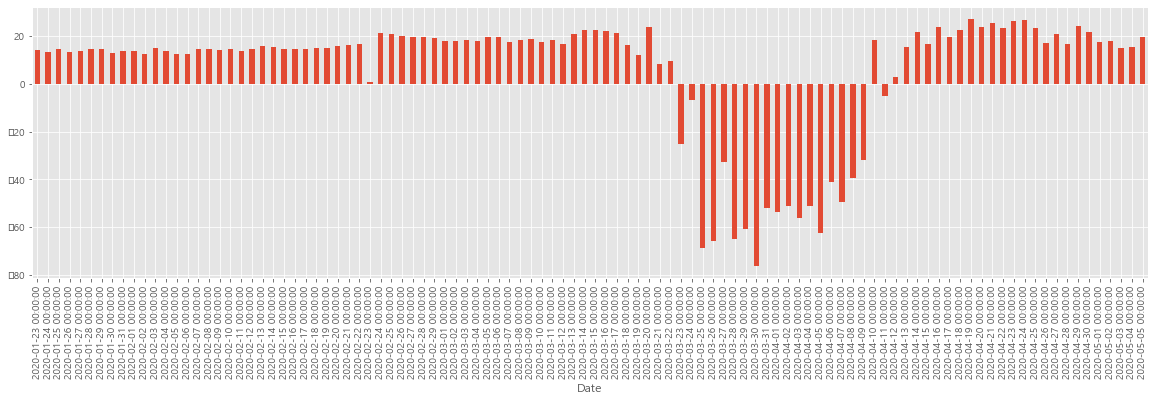

In [101]:
plt.figure(figsize=(20,5))
SR_predict['diff']=SR_predict.predict - df.target
SR_predict['diff'].plot(kind='bar')

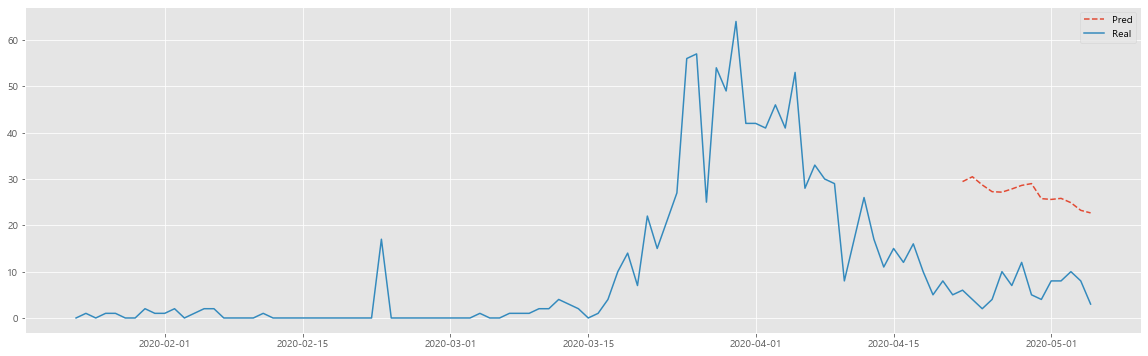

In [102]:
plt.figure(figsize=(20,6))
plt.plot(SR_predict['predict'][-len(X_test):], '--',label='Pred', )
plt.plot(df['target'], label='Real')

plt.legend()

In [103]:
st_reg.predict(X_test)

array([29.43432893, 30.48592358, 28.71953962, 27.26175094, 27.15735104,
       27.84288857, 28.61703119, 29.00198937, 25.7586136 , 25.58833178,
       25.81642875, 24.88627266, 23.23354193, 22.6783895 ])

In [104]:
from sklearn.metrics import r2_score
RSquared = r2_score(y_train, X_train_predict.values)

In [105]:
RSquared

-1.7622056381195095

In [106]:
st_reg.predict(X_test)

array([29.43432893, 30.48592358, 28.71953962, 27.26175094, 27.15735104,
       27.84288857, 28.61703119, 29.00198937, 25.7586136 , 25.58833178,
       25.81642875, 24.88627266, 23.23354193, 22.6783895 ])

In [107]:
preds = pd.DataFrame({'real':y_test,'pred':st_reg.predict(X_test)})

In [108]:
preds['gap'] = preds.real - preds.pred

In [109]:
preds

,real,pred,gap
Date,,,
2020-04-22,6.0,29.434329,-23.434329
2020-04-23,4.0,30.485924,-26.485924
2020-04-24,2.0,28.719540,-26.719540
2020-04-25,4.0,27.261751,-23.261751
2020-04-26,10.0,27.157351,-17.157351
2020-04-27,7.0,27.842889,-20.842889
2020-04-28,12.0,28.617031,-16.617031
2020-04-29,5.0,29.001989,-24.001989
2020-04-30,4.0,25.758614,-21.758614


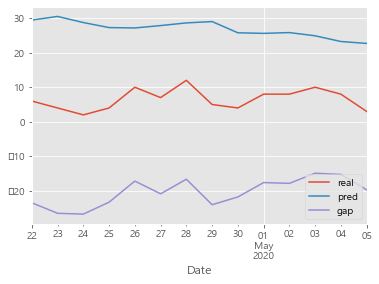

In [110]:
preds.plot()

In [111]:
from sklearn.metrics import mean_squared_error
# validation score
MSE = mean_squared_error(y_test, st_reg.predict(X_test))
RMSE = np.sqrt(MSE)
score = 100*(1-(((st_reg.predict(X_test) - y_test)**2).sum())/(st_reg.predict(X_test)**2).sum())

In [112]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 430.56067381940477, RMSE : 20.74995599560165, SCORE : 40.87314645221242
